In [1]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from M1S_tools import *
import glob

plt.set_cmap('jet')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_165SA_09Jan2025/
Afz =  (27547, 165)
U matrix (27547, 165)
S matrix (165, 165)

<Figure size 640x480 with 0 Axes>

In [2]:
#dateID = '250117' not using dateID. b/c the BMs were split onto quite a few days
TcompString = '' #default, no T compensation
#TcompString = 'comp'

In [3]:
useReMeasured = True
#useReMeasured = False

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 10/250226/250226 GMT3 set1 10.2 5-7 GMTO bm21+ gmtMorph170614 -.h5: Wed Feb 26 09:41:03 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 10/250226/250226 GMT3 set1 10.2 5-7 GMTO bm21- gmtMorph170614 -.h5: Wed Feb 26 09:45:44 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 10/250226/250226 GMT3 set2 10.2 5-7 GMTO bm21- gmtMorph170614 -.h5: Wed Feb 26 09:49:03 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 10/250226/250226 GMT3 set2 10.2 5-7 GMTO bm21+ gmtMorph170614 -.h5: Wed Feb 26 09:53:51 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 10/250226/250226 GMT3 set1 10.2 5-7 GMTO bm22+ gmtMorph170614 -.h5: Wed Feb 26 09:57:50 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 10/250226/250226 GMT3 set1 10.2 5-7 GMTO bm22- gmtMorph170614 -.h5: Wed Feb 26 10:02:05 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_da

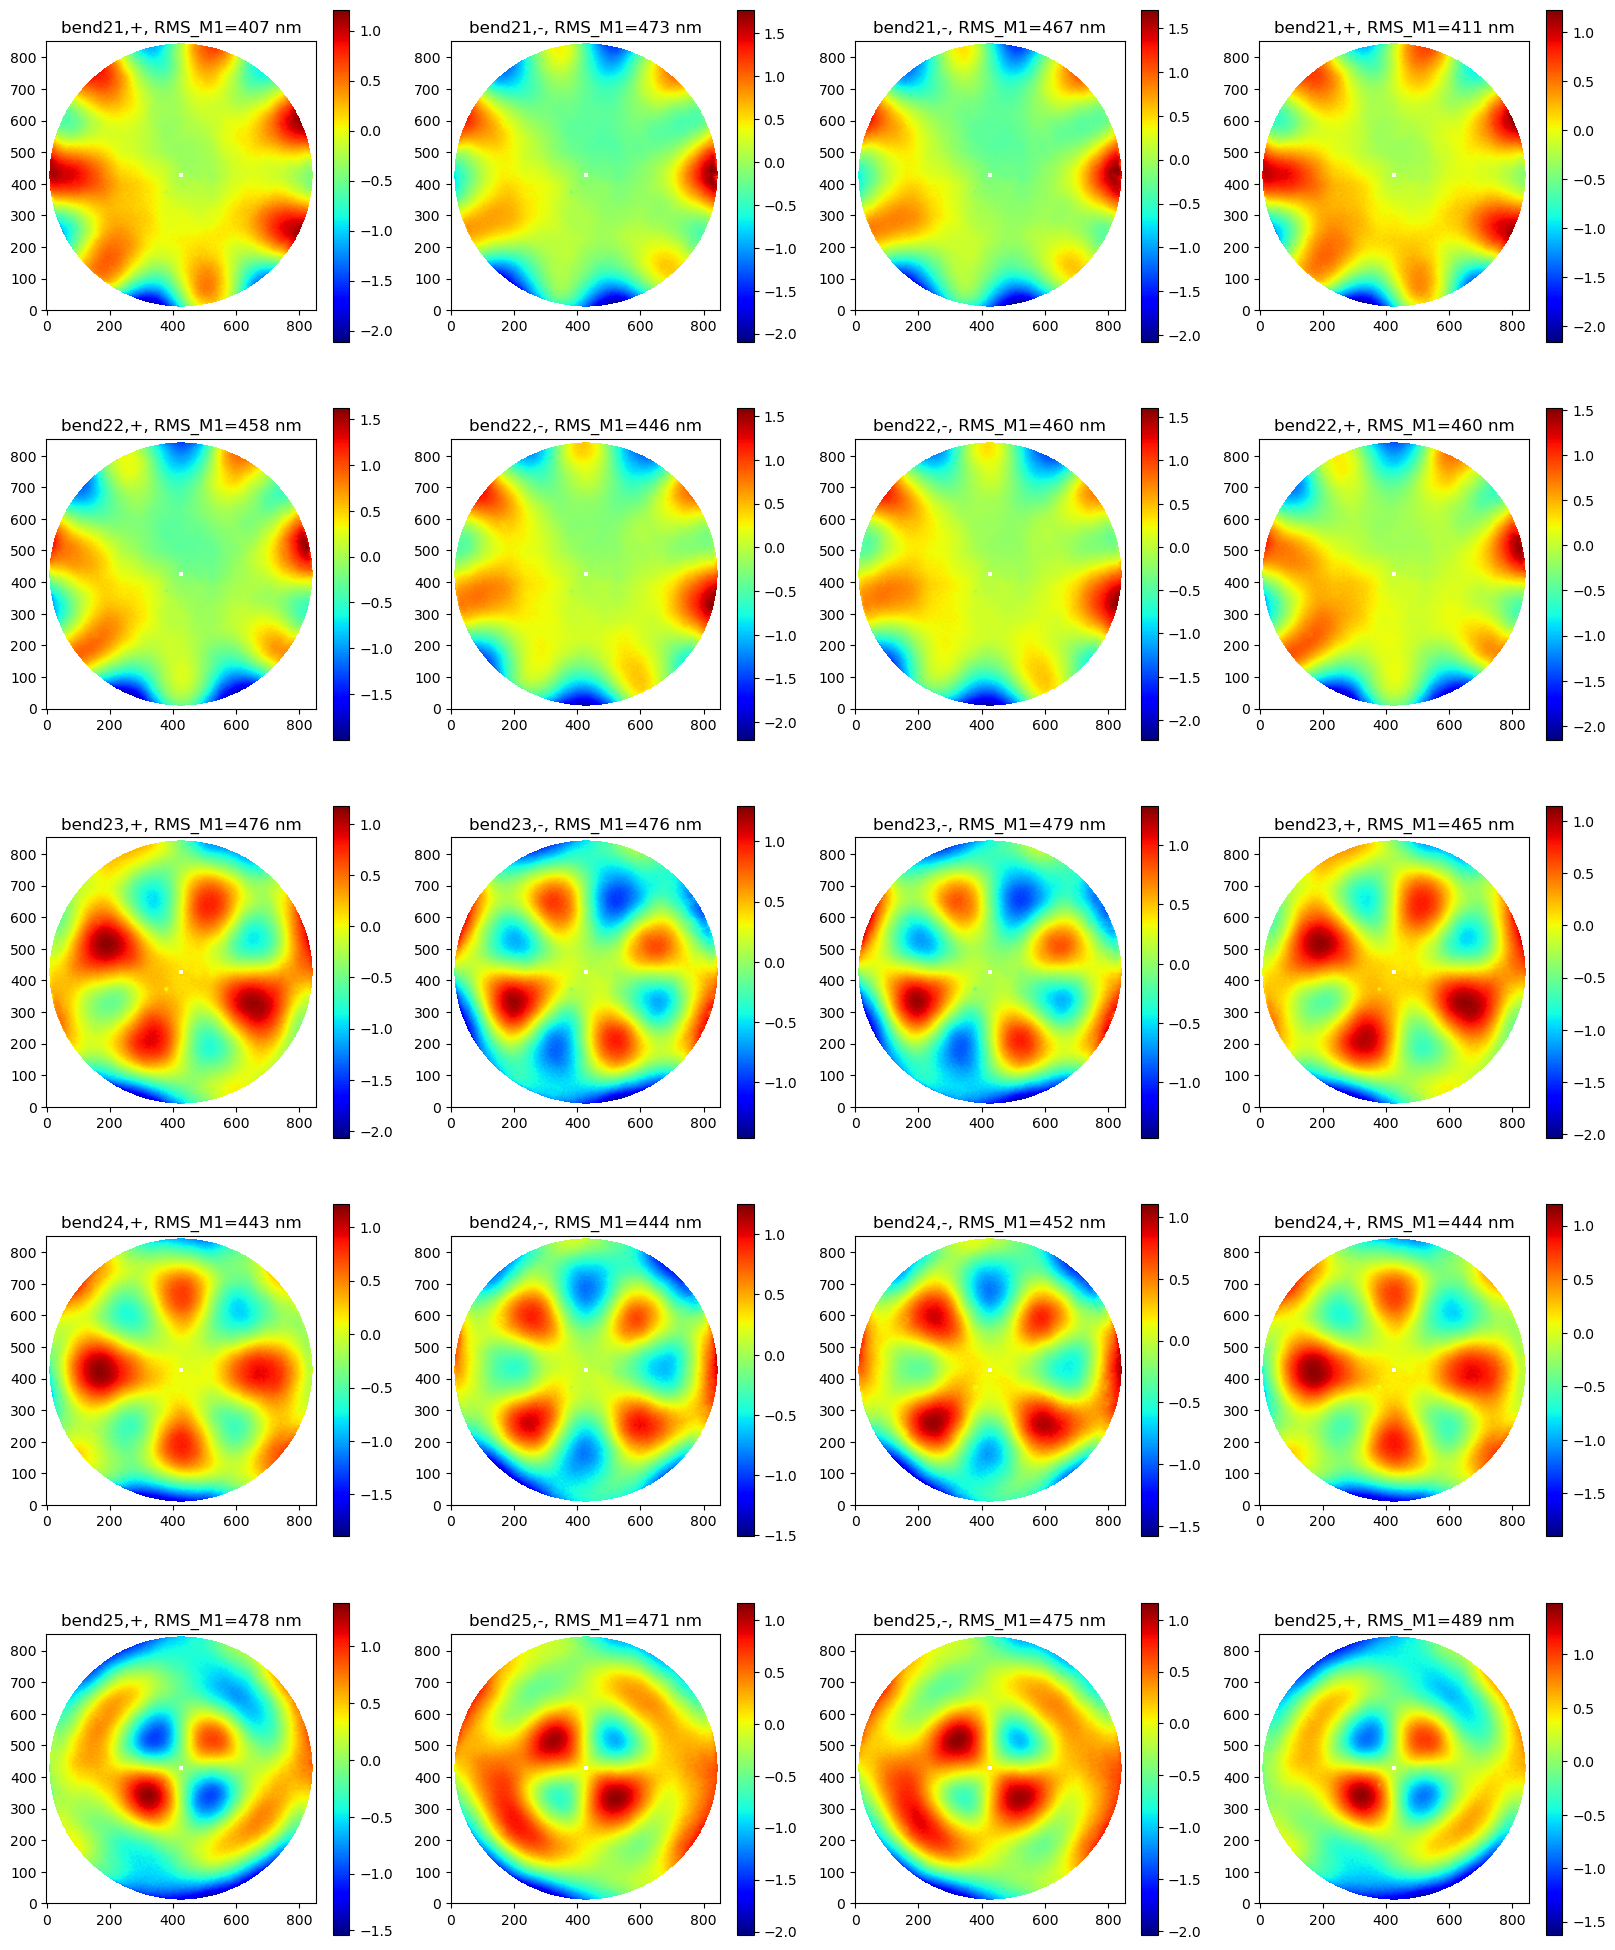

In [5]:
#look at all the +--+ maps, everything in h5 CS
#we repeated 21,22,25
startmode = 21
endmode = 25 #we did not remeasure 23, 24; we run over them here, just to avoid breaking the code
nmode = endmode - startmode+1
ts_array = []
fig, ax = plt.subplots(nmode,4,figsize=(20,5*nmode))
i = 0
for modeID in range(startmode,endmode+1):
    signedBend = ['set1*bm%d+'%modeID, 'set1*bm%d-'%modeID, 'set2*bm%d-'%modeID, 'set2*bm%d+'%modeID]
    for bend in signedBend:
        irow = np.int8(i/4)
        icol = np.mod(i,4)
        i += 1
        
        globstring = '%s/Sec 10/*%s*.h5'%(ml_data_dir, bend) #not using dateID. Data split into 0117 and 0121
        if modeID in [1,2,3,4,5,6]:
            globstring = '%s/250220 GMTO BM 1-6/*%s*.h5'%(ml_data_dir, bend) #not using dateID. 
        elif modeID in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,23,24, 26,27]:
            globstring = '%s/Sec 10/250224/*%s*.h5'%(ml_data_dir, bend)
        elif modeID in [21,22, 25, 28,29,30, 31,32,33,34,35,36,37,38,39,40]: #repeated 21,22,25, 
            globstring = '%s/Sec 10/250226/*%s*.h5'%(ml_data_dir, bend)

        fileset = sorted(glob.glob(globstring))
        assert len(fileset)==1
        m1s,centerRow,centerCol,pixelSize, ts = readH5Map(fileset)
        ts_array.append(ts)
        m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm

        img = ax[irow][icol].imshow(m1s, origin='lower')
        fig.colorbar(img, ax=ax[irow][icol])
        ax[irow][icol].set_title('bend%d,%s, RMS_M1=%.0f nm'%(modeID, bend[-1], m1rms))

In [6]:
len(ts_array)/4

5.0

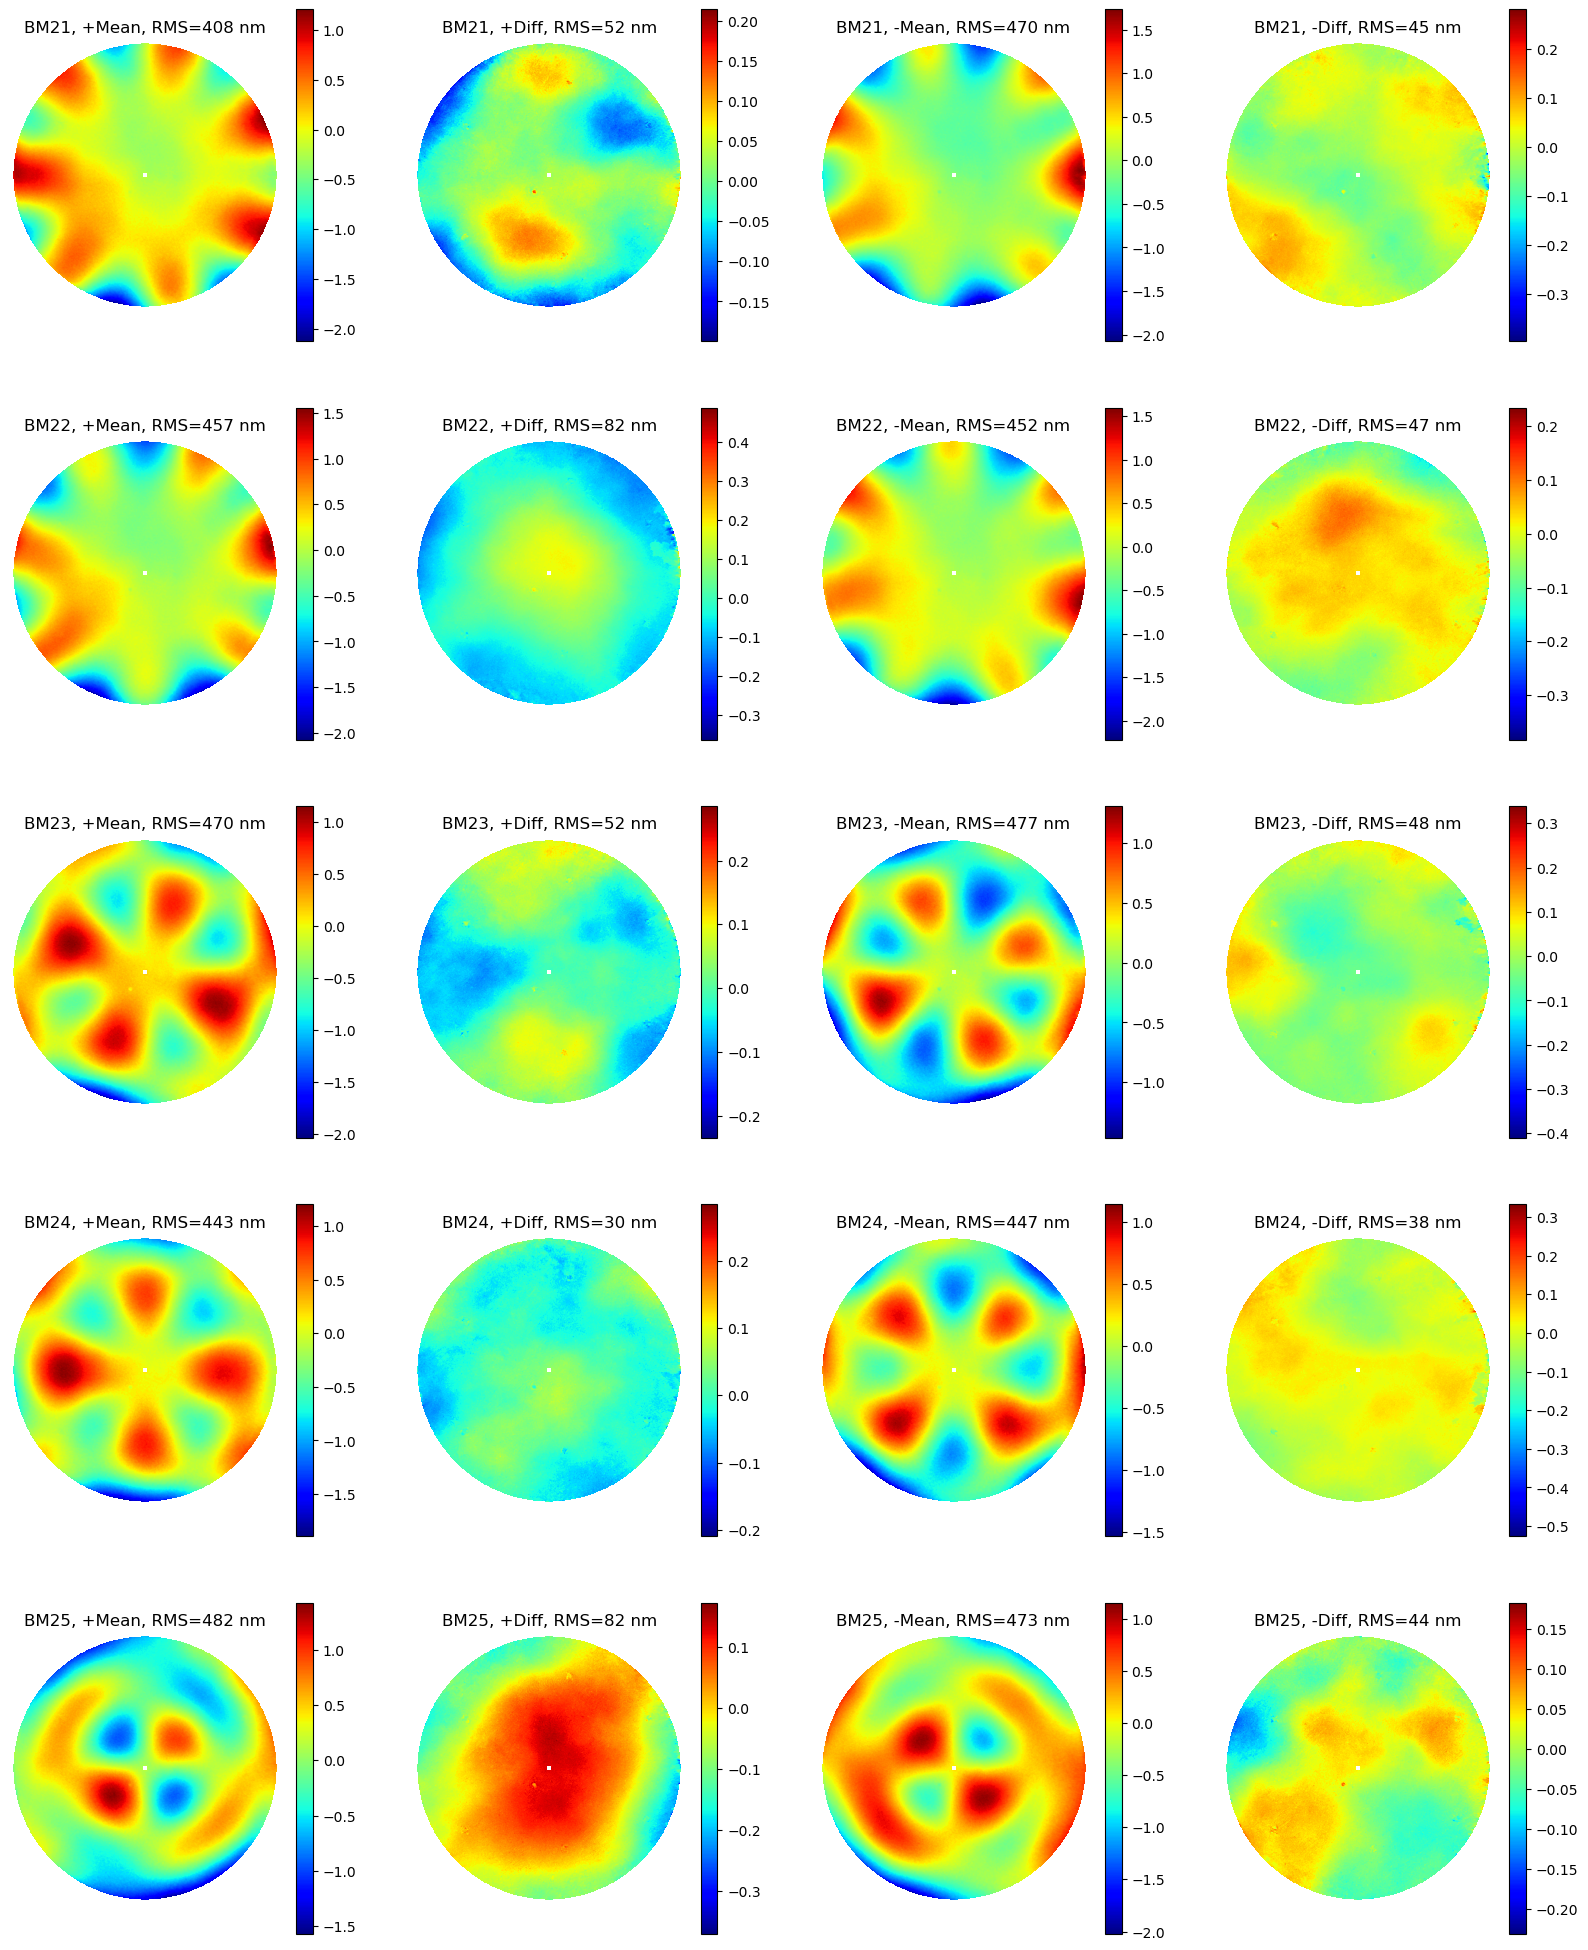

In [7]:
#look at average and diff of each ++ pair and each -- pair; all in h5 CS
stats = np.zeros((4, nmode))
fig, ax = plt.subplots(nmode,4,figsize=(20,5*nmode))
i = 0
for modeID in range(startmode,endmode+1):

    aveplus = np.zeros_like(m1s)
    aveminus = np.zeros_like(m1s)
    diffplus = np.zeros_like(m1s)
    diffminus = np.zeros_like(m1s)
    signedBend = ['set1*bm%d+'%modeID, 'set1*bm%d-'%modeID, 'set2*bm%d-'%modeID, 'set2*bm%d+'%modeID]
    signshort = '+--+'
    for bend in signedBend:

        globstring = '%s/Sec 10/*%s*.h5'%(ml_data_dir, bend) #not using dateID. Data split into 0117 and 0121
        if modeID in [1,2,3,4,5,6]:
            globstring = '%s/250220 GMTO BM 1-6/*%s*.h5'%(ml_data_dir, bend) #not using dateID. 
        elif modeID in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,23,24, 26,27]:
            globstring = '%s/Sec 10/250224/*%s*.h5'%(ml_data_dir, bend)
        elif modeID in [21,22, 25, 28,29,30, 31,32,33,34,35,36,37,38,39,40]: #repeated 21,22,25, 
            globstring = '%s/Sec 10/250226/*%s*.h5'%(ml_data_dir, bend)

        fileset = sorted(glob.glob(globstring))
        #print(fileset)
        assert len(fileset)==1
        m1s,centerRow,centerCol,pixelSize, ts = readH5Map(fileset, verbose=False)
        if '+' in bend:
            aveplus += m1s
            if 'set1' in bend:
                diffplus -= m1s
            else:
                diffplus += m1s #set2 - set1
                aveplus /= 2
        else:
            aveminus += m1s
            if 'set1' in bend:
                diffminus -= m1s
            else:
                diffminus += m1s
                aveminus /= 2
    for j in range(4):
        irow = np.int8(i/4)
        icol = np.mod(i,4)
        i += 1
        if j==0:
            m1s = aveplus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'BM%d, +Mean, RMS=%.0f nm'%(modeID, m1rms)
        elif j==1:
            m1s = diffplus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'BM%d, +Diff, RMS=%.0f nm'%(modeID, m1rms)           
        elif j==2:
            m1s = aveminus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'BM%d, -Mean, RMS=%.0f nm'%(modeID, m1rms)
        elif j==3:
            m1s = diffminus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'BM%d, -Diff, RMS=%.0f nm'%(modeID, m1rms)  
        ax[irow][icol].set_title(mytitle)
        ax[irow][icol].axis('off')
        stats[j, modeID-1-startmode+1] = m1rms

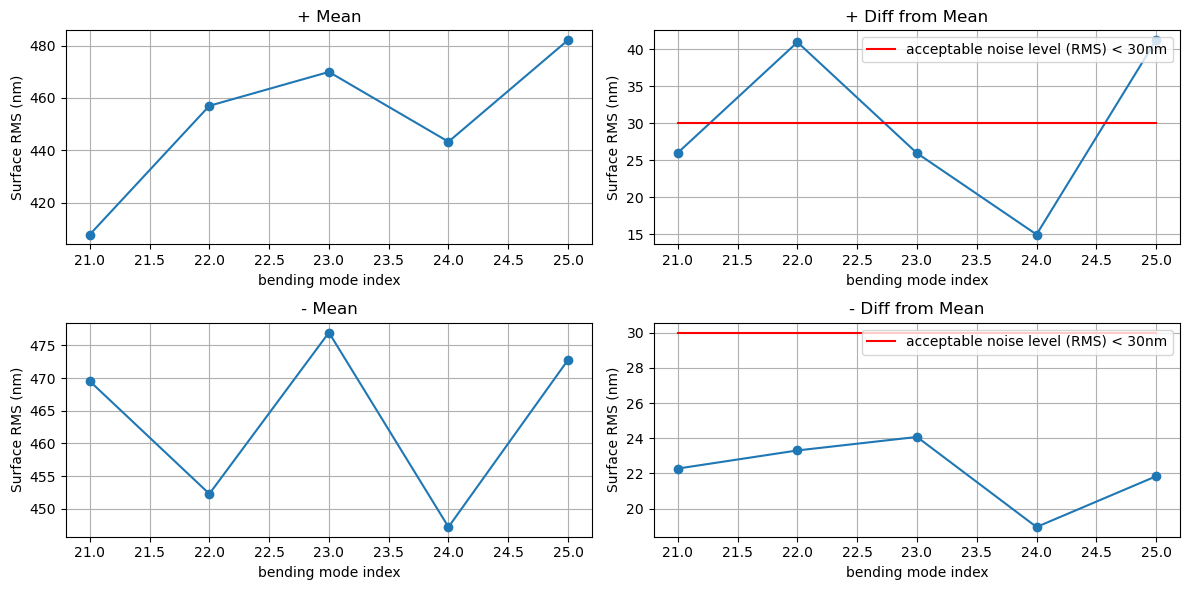

In [8]:
fig, ax = plt.subplots(2,2,figsize=(12, 6))
x0 = np.arange(startmode, endmode+1)
i = 0
j = 0
ax[i][j].plot(x0, stats[0,:],'-o')
ax[i][j].grid()
ax[i][j].set_xlabel('bending mode index')
ax[i][j].set_title('+ Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')
i = 0
j = 1
ax[i][j].plot(x0, stats[j,:]/2,'-o')
ax[i][j].plot([startmode, endmode],[30,30],'-r', label='acceptable noise level (RMS) < 30nm')
ax[i][j].grid()
ax[i][j].legend(loc='upper right')
ax[i][j].set_xlabel('bending mode index')
ax[i][j].set_title('+ Diff from Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')
i = 1
j = 0
ax[i][j].plot(x0, stats[2,:],'-o')
ax[i][j].grid()
ax[i][j].set_xlabel('bending mode index')
ax[i][j].set_title('- Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')
i = 1
j = 1
ax[i][j].plot(x0, stats[3,:]/2,'-o')
ax[i][j].plot([startmode, endmode],[30,30],'-r', label='acceptable noise level (RMS) < 30nm')
ax[i][j].grid()
ax[i][j].legend(loc='upper right')
ax[i][j].set_xlabel('bending mode index')
ax[i][j].set_title('- Diff from Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')
plt.tight_layout()

### Now calculate the measured BMs; We go into M1B from this point on, b/c forces are in shown in M1B

In [9]:
df = pd.read_csv('../test_input_data/BM_amp_sec10.csv')
bmMags = np.array(df['  S RMS(nm)'])/1000.
bmMags[26-1] = 300/1000. #changed in order to avoid actuator force limit (on the quads)
bmMags[27-1] = 180/1000. #changed in order to avoid actuator force limit (on the quads)

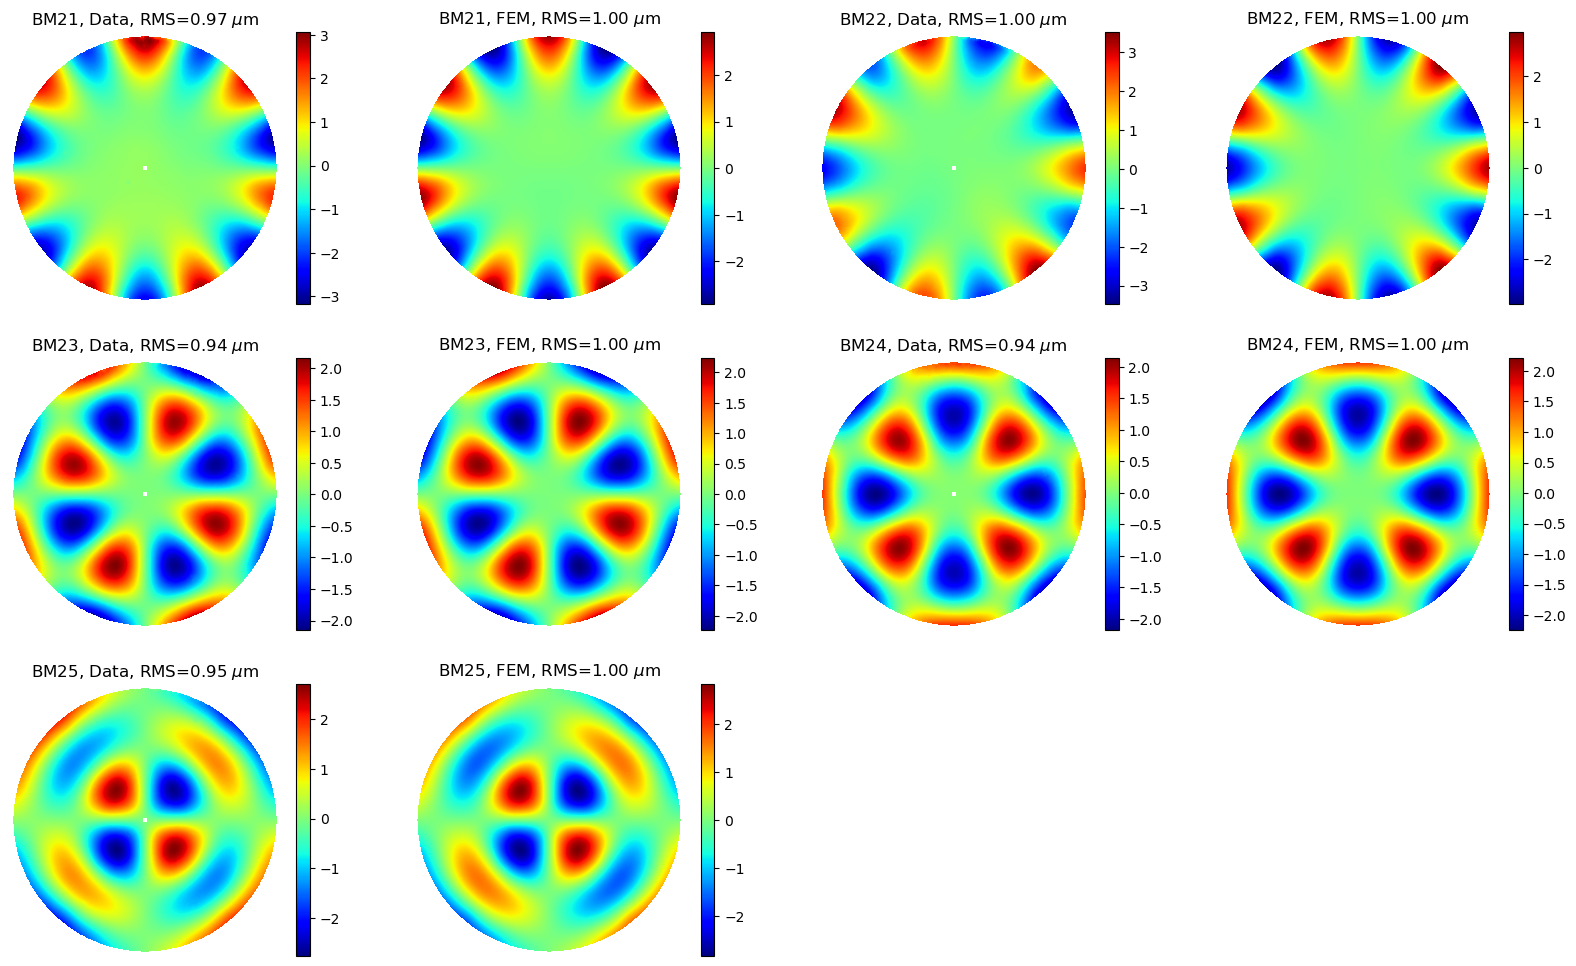

In [10]:
from scipy.interpolate import griddata

GMT_FEM = 1 #GMT FEM, used for side-by-side comparision with measured shapes

#ML FEM; at least visually, this doesn't seem to help; 
#The Afn_ml@VMat are not orthogonal, therefore cannot be used for decomposition.
#GMT_FEM = 0 #ML FEM

#[x1, y1] are the x and y grid in M1B. 
#CenterCol and centerRow are swapped, because they were meant for h5 CS
#Lines below, we will transpose the h5 map to match this.
#.  we will also reverse the sign of h5 maps to be in M1B.
[x1, y1] = mkXYGrid(m1s, centerCol, centerRow, pixelSize)

myBM = np.zeros((Sxn, Syn, nmode))
nrow = int(np.ceil(nmode/2.))
fig, ax = plt.subplots(nrow,4,figsize=(20,4*nrow))

i = 0
for modeID in range(startmode,endmode+1):

    signedBend = ['set1*bm%d+'%modeID, 'set1*bm%d-'%modeID, 'set2*bm%d-'%modeID, 'set2*bm%d+'%modeID]
    signshort = '+--+'    
    for bend in signedBend:
        globstring = '%s/Sec 10/*%s*.h5'%(ml_data_dir, bend) #not using dateID. Data split into 0117 and 0121
        if modeID in [1,2,3,4,5,6]:
            globstring = '%s/250220 GMTO BM 1-6/*%s*.h5'%(ml_data_dir, bend) #not using dateID. 
        elif modeID in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,23,24, 26,27]:
            globstring = '%s/Sec 10/250224/*%s*.h5'%(ml_data_dir, bend)
        elif modeID in [21,22, 25, 28,29,30, 31,32,33,34,35,36,37,38,39,40]: #repeated 21,22,25, 
            globstring = '%s/Sec 10/250226/*%s*.h5'%(ml_data_dir, bend)

        fileset = sorted(glob.glob(globstring))
        #print(fileset)
        assert len(fileset)==1
        m1s,centerRow,centerCol,pixelSize, ts = readH5Map(fileset, verbose=False)
        #m1s *= -1 # we are converting into M1B with myBM[] below
        if '+' in bend:
            myBM[:,:,modeID-startmode] += m1s
        else:
            myBM[:,:,modeID-startmode] -= m1s
    myBM[:,:,modeID-startmode] /= (4*bmMags[modeID-1]) #normalize to 1um RMS surfaces
    myBM[:,:,modeID-startmode] = -myBM[:,:,modeID-startmode].T #convert into M1B
    m1s = myBM[:,:,modeID-startmode]
    m1rms = np.std(m1s[~np.isnan(m1s)])

    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1
    
    img = ax[irow][icol].imshow(m1s, origin='lower')
    fig.colorbar(img, ax=ax[irow][icol])
    mytitle = r'BM%d, Data, RMS=%.2f $\mu$m'%(modeID, m1rms)
    ax[irow][icol].set_title(mytitle)
    ax[irow][icol].axis('off')
    
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1
    
    if GMT_FEM:
        aa = UMat[:,modeID-1]
        m1rms = np.std(aa[~np.isnan(aa)])
        grid_z = griddata((nodex, nodey), UMat[:,modeID-1], (x1,y1), method='linear')
    else:
        ss_mlgrid = Afn_ml @ gmt165Fvec2mlFvec(VMat[:,modeID-1]) * 1e-3
        m1rms = np.std(ss_mlgrid[~np.isnan(ss_mlgrid)])
        grid_z = griddata((np.squeeze(nodex_ml), np.squeeze(nodey_ml)), ss_mlgrid, (x1,y1), method='linear')
    #img = ax[irow][icol].scatter(nodex, nodey,10, UMat[:,modeID-1]) #scatter makes image sampling bad
    img = ax[irow][icol].imshow(grid_z, origin='lower')
    
    ax[irow][icol].set_title(r'BM%d, FEM, RMS=%.2f $\mu$m'%(modeID,m1rms))
    ax[irow][icol].axis('equal')
    ax[irow][icol].axis('off')
    fig.colorbar(img, ax=ax[irow][icol])
    
for i in range(nmode*2, nrow*4):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].axis('off')

(-0.5, 852.5, -0.5, 852.5)

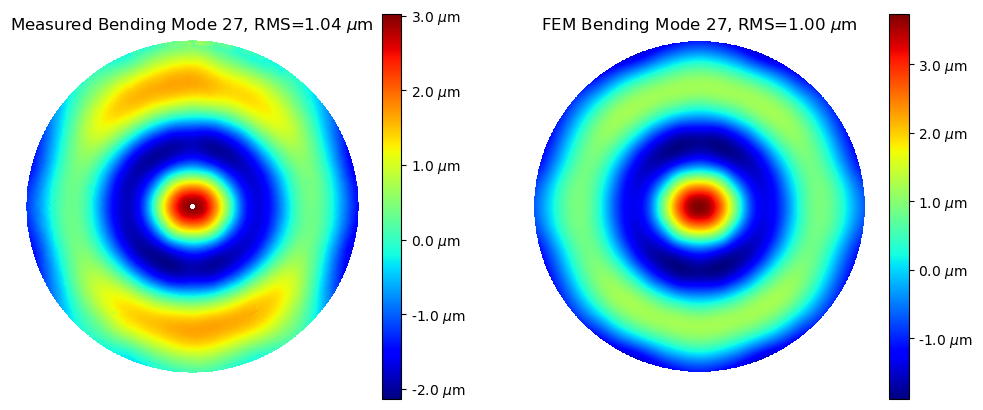

In [11]:
#make a plot for Barbara
#if Barbara wants mode 5, we need to change endmode to 5 from the beginning, so that we can make the plot she wants
fig, ax = plt.subplots(1,2,figsize=(12,5))
img = ax[0].imshow(m1s, origin='lower')
cbar = fig.colorbar(img, ax=ax[0])
m1rms = np.std(m1s[~np.isnan(m1s)])
mytitle = r'Measured Bending Mode %d, RMS=%.2f $\mu$m'%(modeID, m1rms)
ax[0].set_title(mytitle)
ticks = cbar.get_ticks()[1:-1]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.1f} $\mu$m" for tick in ticks])
ax[0].axis('off')

img = ax[1].imshow(grid_z, origin='lower')
cbar = fig.colorbar(img, ax=ax[1])
m1rms = 1.00 #this is FEM
mytitle = r'FEM Bending Mode %d, RMS=%.2f $\mu$m'%(modeID, m1rms)
ax[1].set_title(mytitle)
ticks = cbar.get_ticks()[1:-1]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.1f} $\mu$m" for tick in ticks])
ax[1].axis('off')

In [11]:
bmMags[:endmode]

array([0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 0.5  , 0.5  , 0.471, 0.403, 0.403, 0.492, 0.493,
       0.342, 0.39 , 0.345, 0.339, 0.416, 0.378, 0.377])

### Making the fits & derive xtalks

BM21, Scaling =0.942, Residual RMS = 0.227 micron (per 1 micron RMS expected)
BM22, Scaling =0.947, Residual RMS = 0.310 micron (per 1 micron RMS expected)
BM23, Scaling =0.942, Residual RMS = 0.070 micron (per 1 micron RMS expected)
BM24, Scaling =0.945, Residual RMS = 0.074 micron (per 1 micron RMS expected)
BM25, Scaling =0.938, Residual RMS = 0.168 micron (per 1 micron RMS expected)
scaling factor <1 means mirror stiffer than FEM, i.e., model too soft.


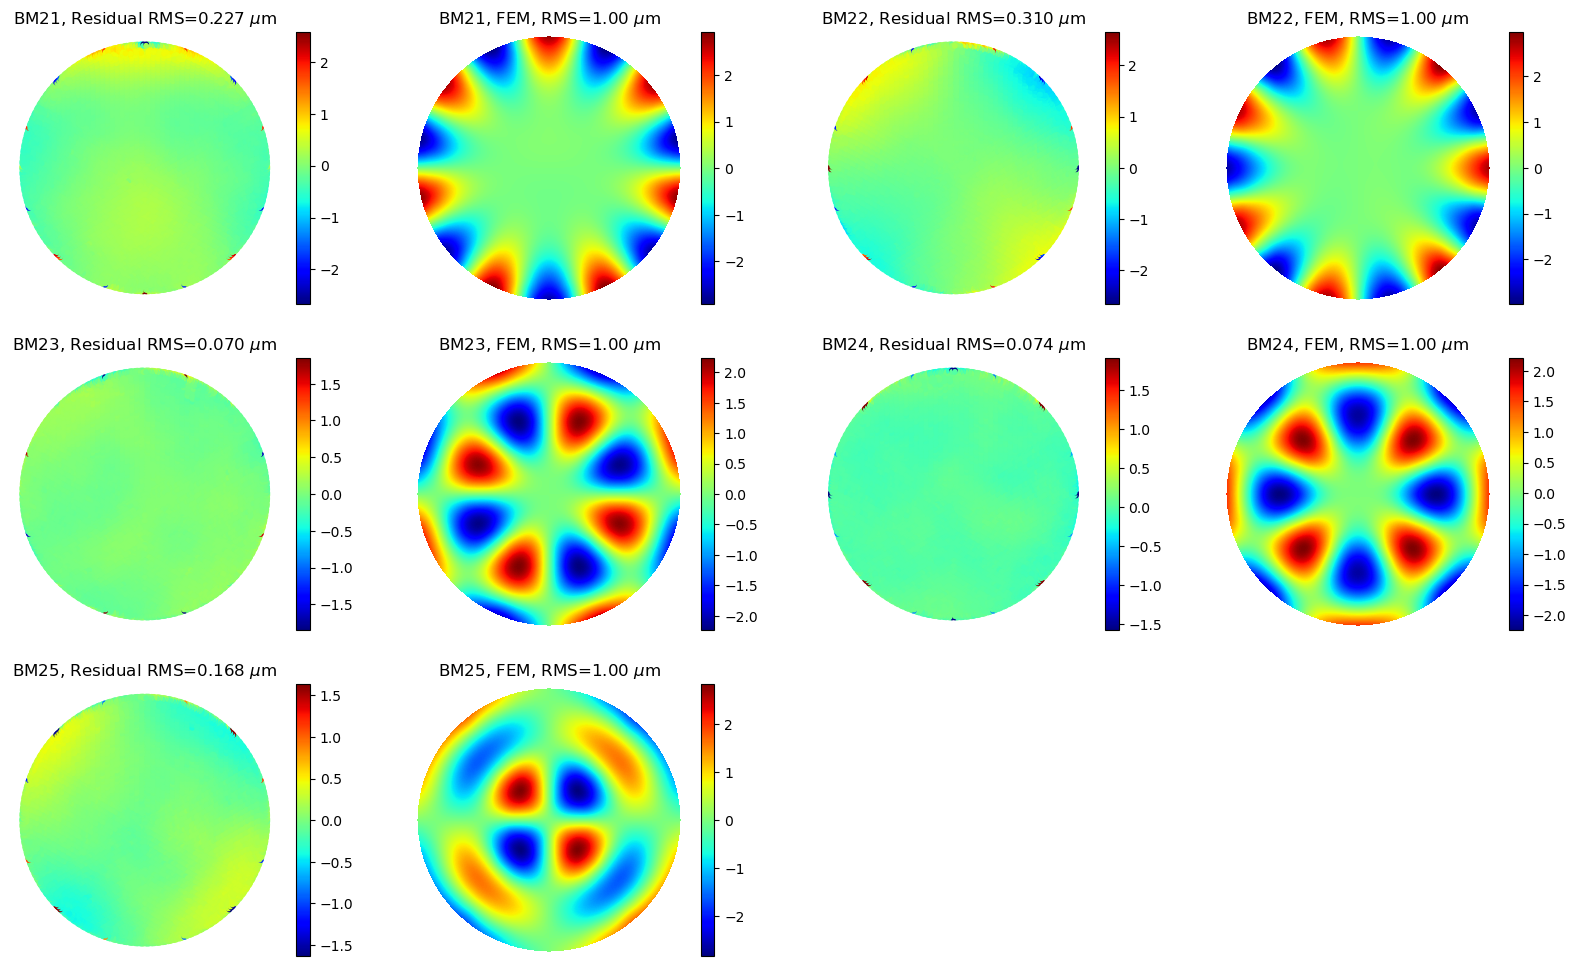

In [12]:
#This takes ~ minutes to run
from scipy.interpolate import LinearNDInterpolator 

nfitmode = 162
xtalk = np.zeros((nfitmode, endmode))

nrow = np.max((int(np.ceil(nmode/2.)),2)) #minimum 2 rows, or ax[irow][icol] won't work
fig, ax = plt.subplots(nrow,4,figsize=(20,4*nrow))
i = 0
for modeID in range(startmode,endmode+1):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1

    bm2d = np.squeeze(myBM[:,:,modeID-1-startmode+1]) #myIF is already in M1B, in nm
    mask = ~np.isnan(bm2d)

    interp = LinearNDInterpolator(list(zip(x1[mask], y1[mask])), bm2d[mask], fill_value=0)
    mapOntoGMTFEgrid = interp(nodex, nodey).ravel()
    xtalk[:,modeID-1] = UMat[:,:nfitmode].transpose() / UMat.shape[0]  @ mapOntoGMTFEgrid #all in micron
    #residual = mapOntoGMTFEgrid - UMat[:,:nfitmode] @ xtalk[:, modeID-1] #this is residual in micron
    #only subtract that one mode
    residual = mapOntoGMTFEgrid - UMat[:,modeID-1] * xtalk[modeID-1, modeID-1] #this is residual in micron
    
    m1rms = np.std(residual[~np.isnan(residual)]) #in micron
    mytitle = r'BM%d, Scaling =%.3f, Residual RMS = %.3f micron (per 1 micron RMS expected)'%(modeID, 
                                                                        np.max(xtalk[:,modeID-1]),
                                                                        m1rms)
    print(mytitle)
    img = ax[irow][icol].scatter(nodex, nodey, 10, residual)
    fig.colorbar(img, ax=ax[irow][icol])
    mytitle = r'BM%d, Residual RMS=%.3f $\mu$m'%(modeID, m1rms)

    ax[irow][icol].set_title(mytitle)
    ax[irow][icol].axis('off')
    
    ###
    
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1
    
    if GMT_FEM:
        aa = UMat[:,modeID-1]
        m1rms = np.std(aa[~np.isnan(aa)])
        grid_z = griddata((nodex, nodey), UMat[:,modeID-1], (x1,y1), method='linear')
    else:
        ss_mlgrid = Afn_ml @ gmt165Fvec2mlFvec(VMat[:,modeID-1]) * 1e-3
        m1rms = np.std(ss_mlgrid[~np.isnan(ss_mlgrid)])
        grid_z = griddata((np.squeeze(nodex_ml), np.squeeze(nodey_ml)), ss_mlgrid, (x1,y1), method='linear')
    #img = ax[irow][icol].scatter(nodex, nodey,10, UMat[:,modeID-1]) #scatter makes image sampling bad
    img = ax[irow][icol].imshow(grid_z, origin='lower')
    
    ax[irow][icol].set_title(r'BM%d, FEM, RMS=%.2f $\mu$m'%(modeID,m1rms))
    ax[irow][icol].axis('equal')
    ax[irow][icol].axis('off')
    fig.colorbar(img, ax=ax[irow][icol])
    
for i in range(nmode, nrow*4):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].axis('off')
print('scaling factor <1 means mirror stiffer than FEM, i.e., model too soft.')

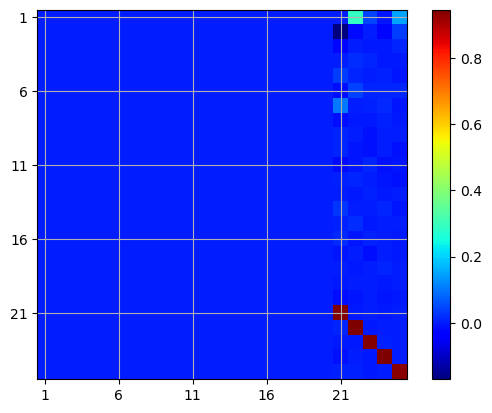

In [13]:
xtalk_sqaure = xtalk[:endmode, :]
plt.imshow(xtalk_sqaure)
rows, cols = xtalk_sqaure.shape
i = 5
plt.xticks(ticks=np.arange(0,cols,i), labels=np.arange(1, cols + 1,i))
plt.yticks(ticks=np.arange(0,rows,i), labels=np.arange(1, rows + 1,i))
plt.grid()
plt.colorbar();

21, -0.171,  2
22, +0.292,  1
23, +0.045,  1
24, -0.026,  2
25, +0.150,  1


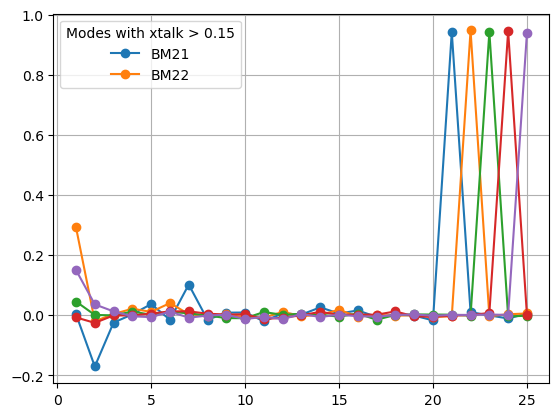

In [14]:
aa = xtalk_sqaure.copy()
np.fill_diagonal(aa,0)
thres = 0.15
maxx = np.zeros(endmode)
contamiID = np.zeros(endmode, dtype=int)
for modeID in range(startmode, endmode+1):
    labelstr = ''
    contamiID[modeID-1] = np.argmax(np.abs(aa[:, modeID-1]))+1 #this is modeID, starts at 1
    maxx[modeID-1] = aa[contamiID[modeID-1]-1, modeID-1]
    if (np.abs(maxx[modeID-1])>thres):
        labelstr = 'BM%d'%modeID
    plt.plot(range(1,endmode+1),xtalk_sqaure[:,modeID-1],'-o', label=labelstr);
    print('%2d, %+.3f, %2d'%(modeID, maxx[modeID-1], contamiID[modeID-1]  ))
plt.legend(title='Modes with xtalk > %.2f'%thres)
#plt.title()
#plt.plot(range(1,nfitmode+1),xtalk,'-o');
plt.grid();

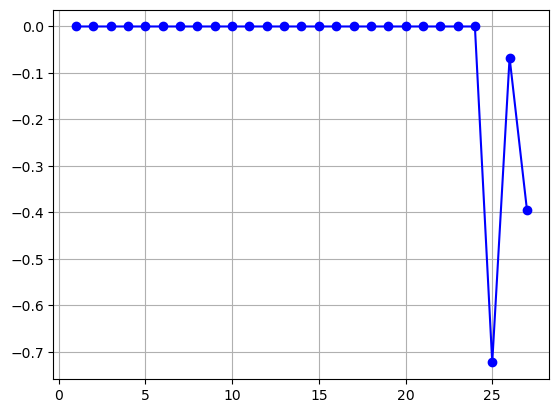

In [18]:
plt.plot(np.arange(1,endmode+1),maxx,'-bo')
plt.grid()
np.savetxt('../model_data/GMT_stiffness_repeat.txt', np.diag(xtalk_sqaure)[25-1:])

### How well does xtalk repeat?

21
[-0.001 -0.208 -0.029 -0.011]
[-0.012 -0.209 -0.033 +0.013]
[+0.003 -0.171 -0.025 +0.002]
22
[+0.304 -0.001 +0.002 +0.033]
[+0.256 -0.035 -0.020 +0.015]
[+0.292 -0.021 +0.003 +0.021]
25
[+0.164 +0.034 -0.002 +0.012]
[+0.171 +0.021 -0.004 +0.009]
[+0.150 +0.035 +0.012 -0.004]


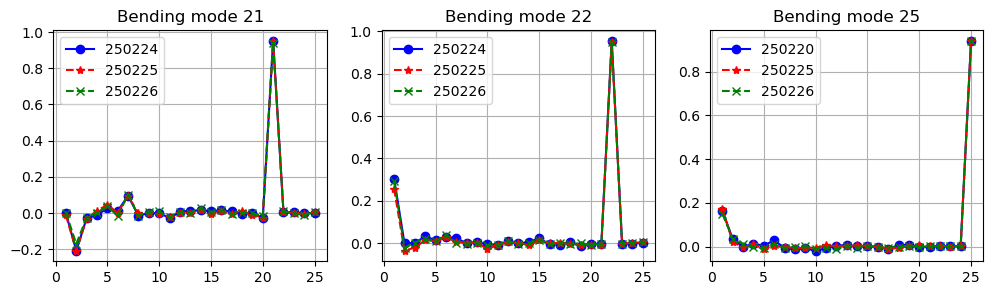

In [17]:
aa = np.loadtxt('../model_data/GMT_xtalk_square.txt')
bb = np.loadtxt('../model_data/GMT_xtalk_square_repeats.txt')
fig, ax = plt.subplots(1,3,figsize=(12,3))
np.set_printoptions(formatter={'float': '{:+.3f}'.format})
for i,modeID in enumerate([21, 22, 25]):
    if modeID==25:
        ax[i].plot(np.arange(1,endmode+1), aa[:endmode,modeID-1],'-bo', label='250220')
    else:
        ax[i].plot(np.arange(1,endmode+1), aa[:endmode,modeID-1],'-bo', label='250224')
        
    ax[i].plot(np.arange(1,endmode+1), bb[:endmode,modeID-1],'--r*', label='250225')
    ax[i].plot(np.arange(1,endmode+1), xtalk_sqaure[:endmode,modeID-1],'--gx', label='250226')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title('Bending mode %d'%modeID)
    print(modeID)
    print(aa[:4,modeID-1])
    print(bb[:4,modeID-1])    
    print(xtalk_sqaure[:4,modeID-1]) #to verify that we are not plotting the same thing twice.

# change this modeID to see coeff for an individual mode

In [82]:
modeID = 27

BM 27
max = +0.35
min = -0.32


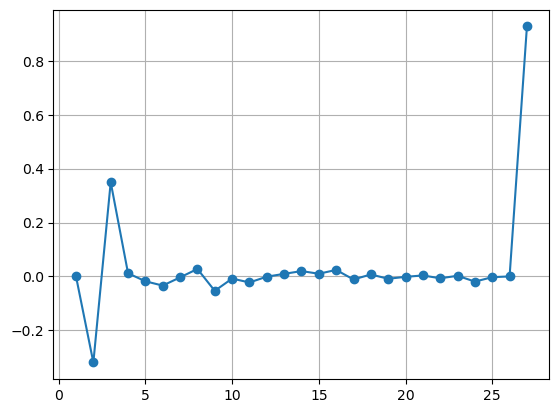

In [83]:
plt.plot(range(1,endmode+1),xtalk_sqaure[:,modeID-1],'-o');
#plt.plot(range(1,nfitmode+1),xtalk[:,modeID-1],'-o');
plt.grid();
aa = xtalk_sqaure[:,modeID-1].copy()
print('BM %d'%modeID)
aa[aa>0.8] = 0
print('max = %+.2f'%aa[np.argmax(aa)])
print('min = %+.2f'%aa[np.argmax(-aa)])

In [30]:
np.argmax(-aa[aa<0.8])+1

1

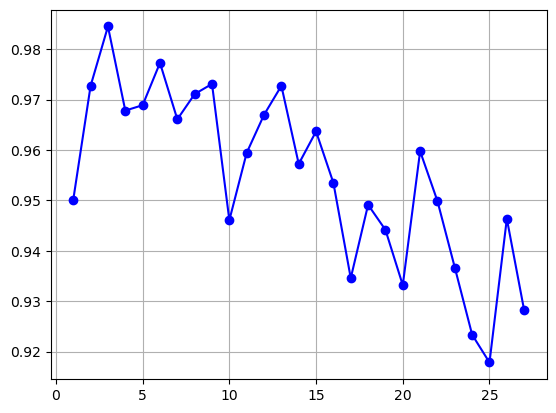

In [31]:
plt.plot(np.arange(1, endmode+1), np.diag(xtalk), '-bo')
plt.grid();

### Check T

In [52]:
t1 = (modeID-endmode)*4-4 #these are indices for locating the timestamps
t2 = t1+1
t3 = t1+2
t4 = t1+3
print(ts_array[t1], '\n', ts_array[t2], '\n', ts_array[t3], '\n', ts_array[t4])

Tue Jan 21 15:17:08 2025 
 Tue Jan 21 15:21:20 2025 
 Tue Jan 21 15:24:41 2025 
 Tue Jan 21 15:28:50 2025


----------------   Tue Jan 21 15:17:08 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-21 15:17:08  duration =  100  s
(1, 6, 32)
(1, 192)
----------------   Tue Jan 21 15:21:20 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-21 15:21:20  duration =  100  s
(1, 6, 32)
(1, 192)
----------------   Tue Jan 21 15:24:41 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-21 15:24:41  duration =  100  s
(1, 6, 32)
(1, 192)
----------------   Tue Jan 21 15:28:50 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-21 15:28:50  duration =  100  s
(1, 6, 32)
(1, 192)


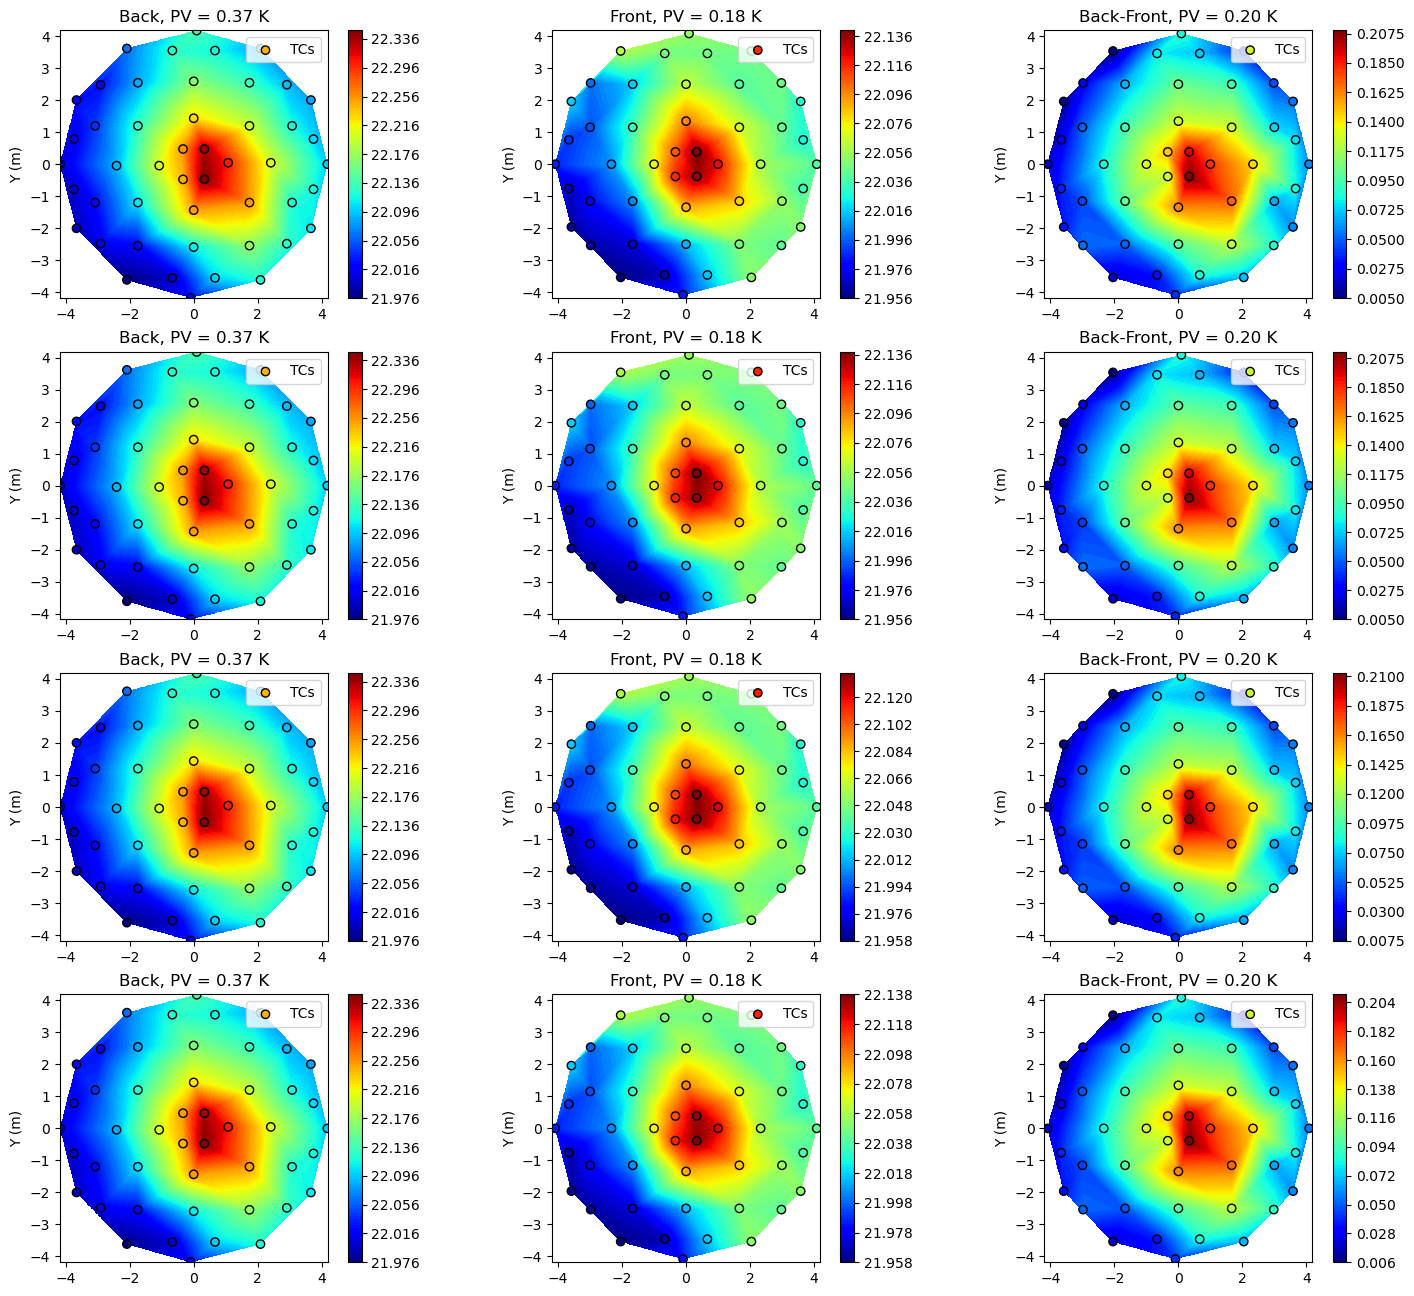

In [33]:
showTMaps([ts_array[t1], ts_array[t2], ts_array[t3], ts_array[t4]])

### Measurement noise?

In [34]:
#for 1um of bm25, we see 0.72um of bm1
print("for 377nm of bm25 measured, there were %.0f nm bm1 produced"%(0.72*377))
print("if this much bm1 were also present due to measurement noise, scaling factor for bm1 would have been %.2f"%(
(500+271)/500))

for 377nm of bm25 measured, there were 271 nm bm1 produced
if this much bm1 were also present due to measurement noise, scaling factor for bm1 would have been 1.54


### Check force telemetry: force differential

In [53]:
print(t1, t2)
sa_force1, tt = getDBData(unix_ts(ts_array[t1])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force1_ave = np.mean(sa_force1,axis=0)
print(sa_force1.shape)
sa_force2, tt = getDBData(unix_ts(ts_array[t2])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force2_ave = np.mean(sa_force2,axis=0)
print(sa_force2.shape)
sa_force3, tt = getDBData(unix_ts(ts_array[t3])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force3_ave = np.mean(sa_force3,axis=0)
print(sa_force3.shape)
sa_force4, tt = getDBData(unix_ts(ts_array[t4])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force4_ave = np.mean(sa_force4,axis=0)
print(sa_force4.shape)

-12 -11
m1_s1_support_ctrl/s/sa_force/value
2025-01-21 15:15:08  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/s/sa_force/value
2025-01-21 15:19:20  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/s/sa_force/value
2025-01-21 15:22:41  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/s/sa_force/value
2025-01-21 15:26:50  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)


In [54]:
expectedF = gmt165Fvec2gmt170Fvec(VMat[:, modeID-1])

input forces and output figure both in M1B


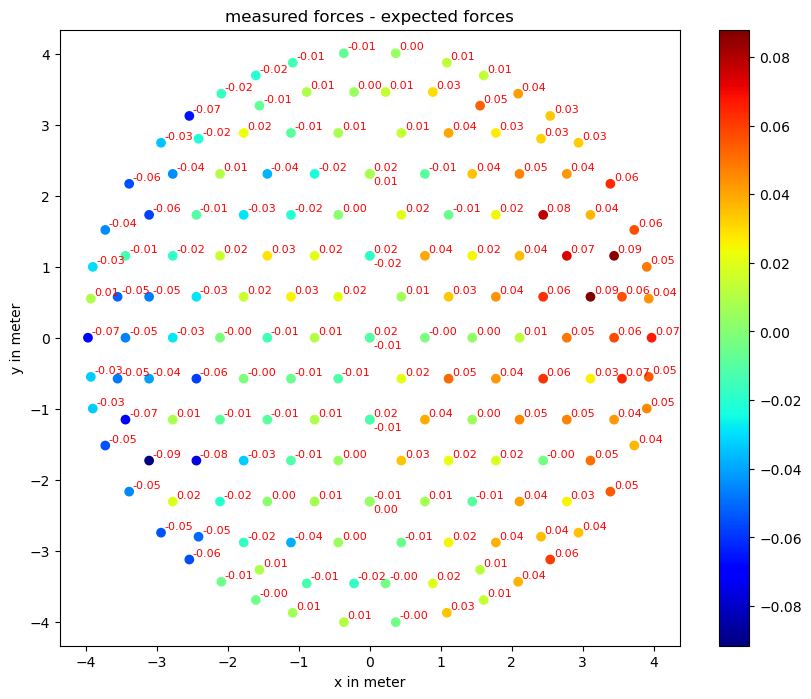

In [55]:
fdiff1 = (sa_force1_ave[:,2]-sa_force2_ave[:,2])/2 - expectedF*bmMags[modeID-1]
showForceMap_M1B(fdiff1, 'measured forces - expected forces', precision=2)
#showForceMap_M1B(expectedF*bmMags[modeID-1], 'bb')

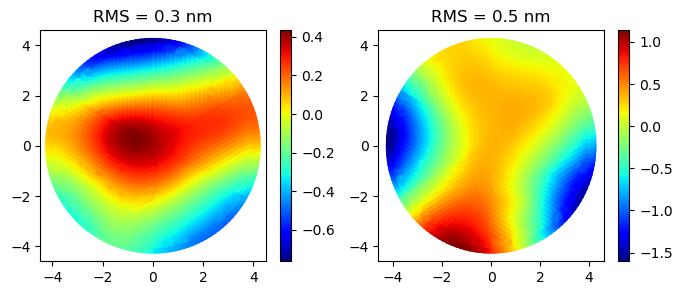

In [57]:
fdiff2 = (sa_force4_ave[:,2]-sa_force3_ave[:,2])/2 - expectedF*bmMags[modeID-1]

fig, ax = plt.subplots(1,2, figsize=(8,3))
sdiff1 = Afz @ gmt170Fvec2gmt165Fvec(fdiff1)*1e9 #convert to nm
img = ax[0].scatter(nodex, nodey, 10,  sdiff1)
aarms = np.nanstd(sdiff1)
ax[0].set_title('RMS = %.1f nm'%aarms)
ax[0].axis('equal')
fig.colorbar(img, ax=ax[0])
sdiff2 = Afz @ gmt170Fvec2gmt165Fvec(fdiff2)*1e9 #convert to nm
img = ax[1].scatter(nodex, nodey, 10,  sdiff2)
aarms = np.nanstd(sdiff2)
ax[1].set_title('RMS = %.1f nm'%aarms)
fig.colorbar(img, ax=ax[1]);

In [58]:
fdiff1x = (sa_force1_ave[:,0]-sa_force2_ave[:,0])/2
fdiff2x = (sa_force4_ave[:,0]-sa_force3_ave[:,0])/2
fdiff1y = (sa_force1_ave[:,1]-sa_force2_ave[:,1])/2
fdiff2y = (sa_force4_ave[:,1]-sa_force3_ave[:,1])/2
fdiff1x.shape, Afx.shape

((170,), (27547, 165))

In [59]:
fdiff1x[-10:]

array([ 0.02034503,  0.03631693,  0.04881435,  0.01916053,  0.00673741,
        0.03285222,  0.0364579 ,  0.04438667, -0.00562455, -0.0070478 ])

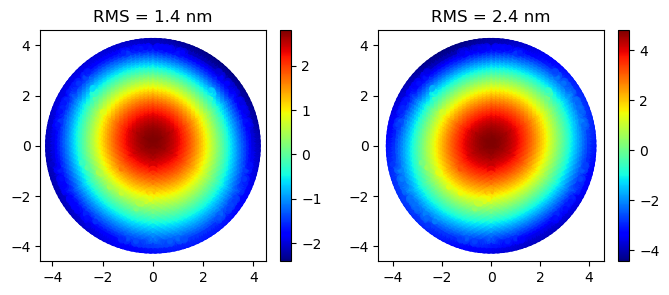

In [60]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
sdiff1 = Afx @ gmt170Fvec2gmt165Fvec(fdiff1x)*1e9 #convert to nm
img = ax[0].scatter(nodex, nodey, 10,  sdiff1)
aarms = np.nanstd(sdiff1)
ax[0].set_title('RMS = %.1f nm'%aarms)
ax[0].axis('equal')
fig.colorbar(img, ax=ax[0])
sdiff2 = Afx @ gmt170Fvec2gmt165Fvec(fdiff2x)*1e9 #convert to nm
img = ax[1].scatter(nodex, nodey, 10,  sdiff2)
aarms = np.nanstd(sdiff2)
ax[1].set_title('RMS = %.1f nm'%aarms)
fig.colorbar(img, ax=ax[1]);

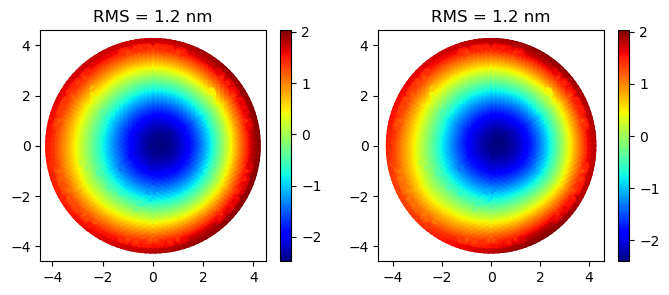

In [61]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
sdiff1 = Afy @ gmt170Fvec2gmt165Fvec(fdiff1y)*1e9 #convert to nm
img = ax[0].scatter(nodex, nodey, 10,  sdiff1)
aarms = np.nanstd(sdiff1)
ax[0].set_title('RMS = %.1f nm'%aarms)
ax[0].axis('equal')
fig.colorbar(img, ax=ax[0])
sdiff2 = Afy @ gmt170Fvec2gmt165Fvec(fdiff2y)*1e9 #convert to nm
img = ax[1].scatter(nodex, nodey, 10,  sdiff2)
aarms = np.nanstd(sdiff2)
ax[1].set_title('RMS = %.1f nm'%aarms)
fig.colorbar(img, ax=ax[1]);

In [62]:
##find the force command from DB
fcmd1, tt = getDBData(unix_ts(ts_array[t1])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)
fcmd2, tt = getDBData(unix_ts(ts_array[t2])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)
fcmd3, tt = getDBData(unix_ts(ts_array[t3])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)
fcmd4, tt = getDBData(unix_ts(ts_array[t4])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)

m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-21 15:15:08  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-21 15:19:20  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-21 15:22:41  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-21 15:26:50  duration =  120  s
(120, 170, 3)
(120, 170, 3)


In [63]:
sa_force1.shape

(120, 170, 3)

In [64]:
if 1:
    fdiff_inst_1 = sa_force1[:,:,2] - fcmd1[:,:,2]
    fdiff_inst_2 = sa_force2[:,:,2] - fcmd2[:,:,2]
    fdiff_inst_3 = sa_force3[:,:,2] - fcmd3[:,:,2]
    fdiff_inst_4 = sa_force4[:,:,2] - fcmd4[:,:,2]
else: #subtract initial forces in the 120 time perids    
    sa_force1[:,:,2] -= np.tile(sa_force1[0,:,2],(sa_force1.shape[0],1))
    sa_force2[:,:,2] -= np.tile(sa_force2[0,:,2],(sa_force2.shape[0],1))
    sa_force3[:,:,2] -= np.tile(sa_force3[0,:,2],(sa_force3.shape[0],1))
    sa_force4[:,:,2] -= np.tile(sa_force4[0,:,2],(sa_force4.shape[0],1))

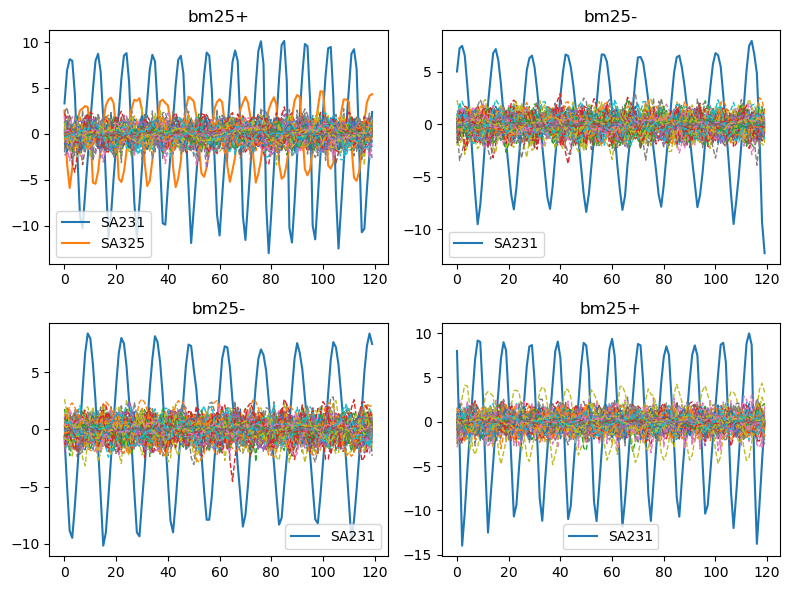

In [65]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

for k in range(4):
    irow = np.int8(k//2)
    icol = np.mod(k,2)
    if k==0:
        fol_err = fdiff_inst_1 
    elif k==1:
        fol_err = fdiff_inst_2
    elif k==2:
        fol_err = fdiff_inst_3
    elif k==3:
        fol_err = fdiff_inst_4

    thres = 5
    for i in range(nact):
        if np.max(np.abs(fol_err[:,i]))>thres:
            ax[irow][icol].plot(fol_err[:,i], label='SA%s'%(saID[i+1]))
    ax[irow][icol].legend()
    ax[irow][icol].set_title('bm%d%s'%(modeID, signshort[k]))
    for i in range(nact):
        if np.max(np.abs(fol_err[:,i]))<=thres:
            ax[irow][icol].plot(fol_err[:,i], '--', linewidth=1)
plt.tight_layout()

In [66]:
print(np.mean(fdiff_inst_1[:,saID==231], axis=0))

[-0.01695201]


### Take the largest instantaneous force difference, and turn into bending modes. That shows the worst case

In [67]:
max_idx = np.unravel_index(np.argmax(fdiff_inst_1), fdiff_inst_1.shape)
worst_shape = (Afz@gmt170Fvec2gmt165Fvec(fdiff_inst_1[max_idx[0],:]))*1e6 #turn m into micron
worst_coeff = UMat[:,:nfitmode].transpose() / UMat.shape[0]  @ worst_shape #all in micron

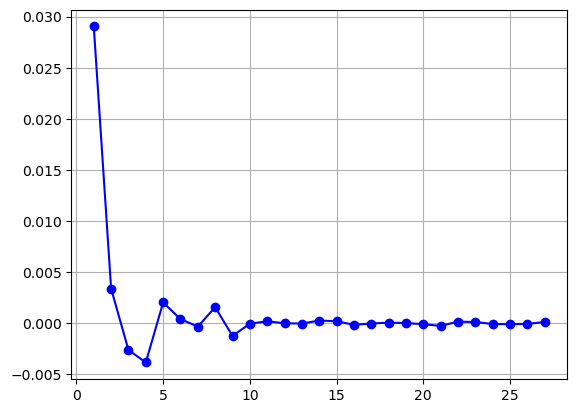

In [68]:
plt.plot(np.arange(1,27+1), worst_coeff[:27], '-bo')
plt.grid();

more investigations that could be done to gain more insights.

1. shift the 120s back by a few seconds, like, 3s, 5s, 8s, and check the force difference.
2. Dave also suggested to turn T change into bending modes and see the impact. The easist thing to do there would be to ask Will to process those surface maps with T compensation.

In [69]:
fol_err1, tt = getDBData(unix_ts(ts_array[t1])-120,'m1_s1_support_ctrl/o/sa_following_error/value', duration_in_s=120, samples=120)
fol_err2, tt = getDBData(unix_ts(ts_array[t2])-120,'m1_s1_support_ctrl/o/sa_following_error/value', duration_in_s=120, samples=120)
fol_err3, tt = getDBData(unix_ts(ts_array[t3])-120,'m1_s1_support_ctrl/o/sa_following_error/value', duration_in_s=120, samples=120)
fol_err4, tt = getDBData(unix_ts(ts_array[t4])-120,'m1_s1_support_ctrl/o/sa_following_error/value', duration_in_s=120, samples=120)

m1_s1_support_ctrl/o/sa_following_error/value
2025-01-21 15:15:08  duration =  120  s
(121, 170, 3)
(121, 170, 3)
m1_s1_support_ctrl/o/sa_following_error/value
2025-01-21 15:19:20  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/o/sa_following_error/value
2025-01-21 15:22:41  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/o/sa_following_error/value
2025-01-21 15:26:50  duration =  120  s
(120, 170, 3)
(120, 170, 3)


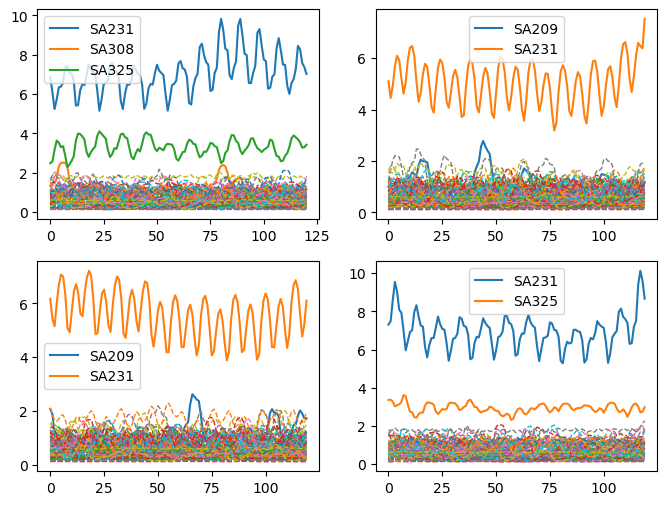

In [70]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

for k in range(4):
    irow = np.int8(k//2)
    icol = np.mod(k,2)
    if k==0:
        fol_err = fol_err1
    elif k==1:
        fol_err = fol_err2
    elif k==2:
        fol_err = fol_err3
    elif k==3:
        fol_err = fol_err4

    thres = 2.5
    for i in range(nact):
        if np.max(fol_err[:,i,2])>=thres:
            ax[irow][icol].plot(fol_err[:,i,2], label='SA%s'%(saID[i+1]))
    ax[irow][icol].legend();
    for i in range(nact):
        if np.max(fol_err[:,i,2])<thres:
            ax[irow][icol].plot(fol_err[:,i,2], '--', linewidth=1)


In [71]:
previousH5 = unix_ts(ts_array[t1-1])
currentH5 = unix_ts(ts_array[t1])
duration_in_s = currentH5 - previousH5
print('previous h5 timestamp (bm%d+) = '%(modeID-1),ts_array[t1-1], previousH5)
print('current h5 timestamp (bm%d+)= '%modeID, ts_array[t1], currentH5)
print('duration = ', duration_in_s, ' seconds')

client = MongoClient(HOST, PORT)
tele = client.gmt_tele_1.tele_events

table_name = "m1_s1_support_ctrl/i/sa_force_commanded/value"
records = tele.find({"ts":{"$gt":previousH5*1000000000.0,"$lt":currentH5*1000000000.0},
                 "src":{"$eq":f"{table_name}"}})
#for record in records:
#    print(record['value'])
print('number of records = ', len(list(records)))

previous h5 timestamp (bm24+) =  Tue Jan 21 15:09:29 2025 1737497369
current h5 timestamp (bm25+)=  Tue Jan 21 15:17:08 2025 1737497828
duration =  459  seconds
number of records =  4590


### force command vs what we wanted to apply

27 -4 command_1737501402.txt
(165,)
1 1737501633


Text(0.5, 1.0, 'bending force command - what should be appled')

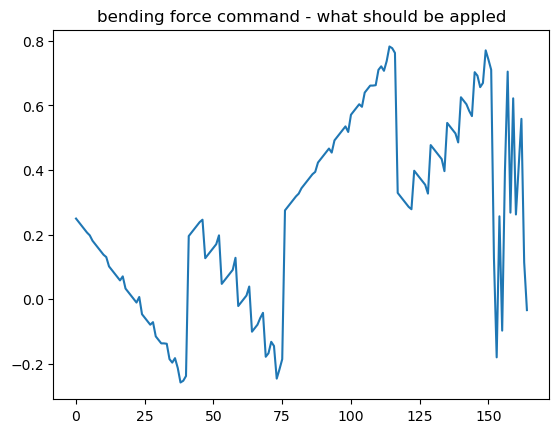

In [116]:
df = pd.read_csv(ml_data_dir+'/../../initial_optimized_forces.txt', header=None)
fpart2 = np.array(df[1])
filename = find_cmd_file(ml_data_dir+ "/../../cmd_logs/", unix_ts(ts_array[t1]))
print(modeID, t1, filename.split('/')[-1])
df = pd.read_csv(filename, header=None)
mlbfp1 = np.array(df[1])
print(mlbfp1.shape)

mysign = 1
if np.mod(t1,4)==2 or np.mod(t1,4)==1:
    mysign = -1
print(mysign, unix_ts(ts_array[t1]))
plt.plot(mlbfp1-fpart2-mysign*VMat[:,modeID-1]*bmMags[modeID-1])
plt.title('bending force command - what should be appled')

### what we sent to ML vs what we wanted to apply

27 initial_optimized_forces_bm27_p180.txt
(165,)


Text(0.5, 1.0, 'bending force command - what should be appled')

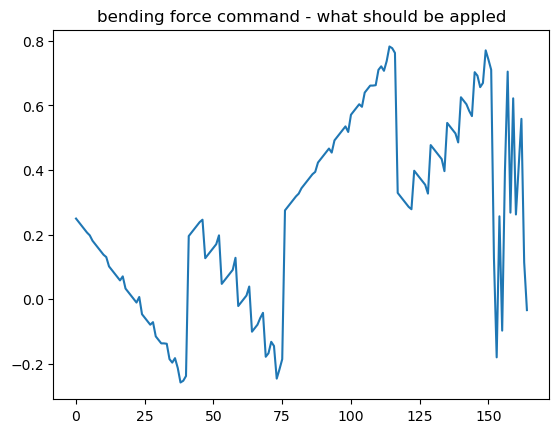

In [117]:
mysign = 'p'

df = pd.read_csv(ml_data_dir+'/../../initial_optimized_forces.txt', header=None)
fpart2 = np.array(df[1])

filename = glob.glob(ml_data_dir+'/../../section_10/initial_optimized_forces_bm%d_%s%d.txt'%(
    modeID,mysign, bmMags[modeID-1]*1000))[0]
print(modeID, filename.split('/')[-1])
df = pd.read_csv(filename, header=None)
mlbfp2 = np.array(df[1])
print(mlbfp2.shape)

if mysign=='p':
    mysign = 1
else:
    mysign = -1
plt.plot(mlbfp2-fpart2-mysign*VMat[:,modeID-1]*bmMags[modeID-1])
plt.title('bending force command - what should be appled')

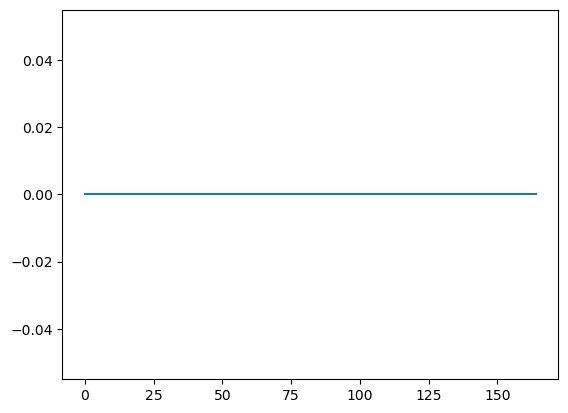

In [118]:
plt.plot(mlbfp2-mlbfp1);

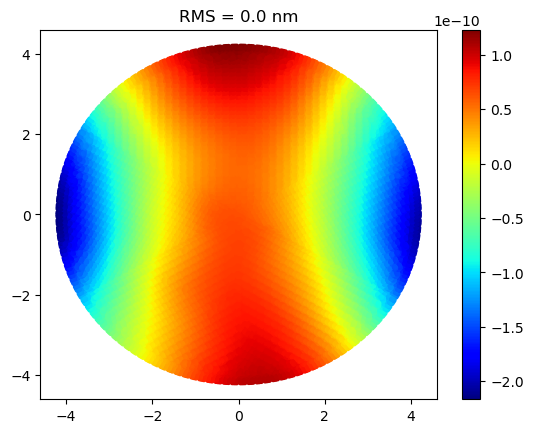

In [59]:
fdiff = mlbfp2-fpart2-mysign*VMat[:,modeID-1]*bmMags[modeID-1]
aa = Afz @ fdiff*1e9 #convert to nm
plt.scatter(nodex, nodey, 10,  aa)
aarms = np.nanstd(aa)
plt.title('RMS = %.1f nm'%aarms)
plt.colorbar();

input forces and output figure both in M1B


0.2836339953075466

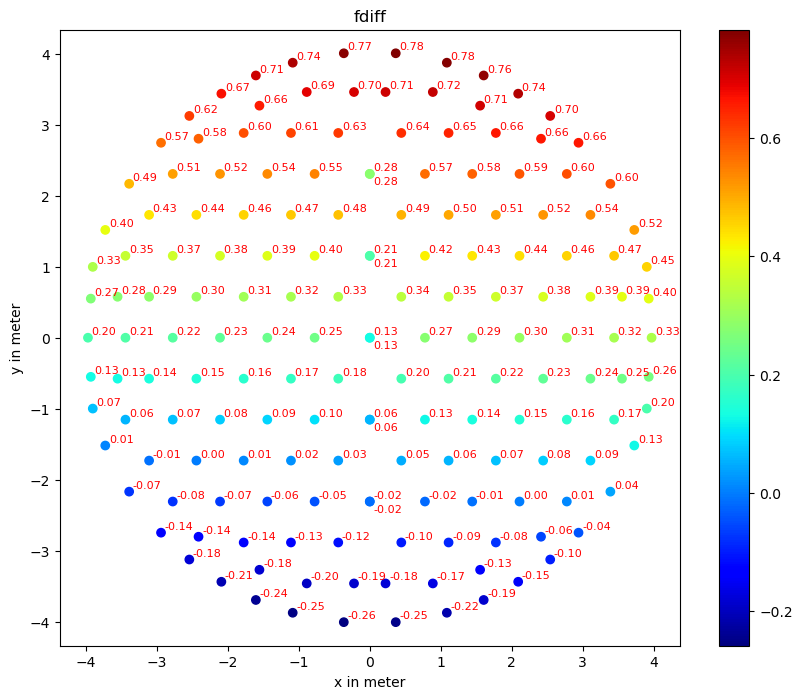

In [60]:
showForceMap_M1B(gmt165Fvec2gmt170Fvec(fdiff),'fdiff', precision=2)
np.nanstd(fdiff)

In [ ]:
aa.shape